In [2]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import medmnist

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [3]:
from src.models import *
from src.functions import *
from src.data import *
from src.rvae import *
from src.trainer import *
from src.classifier import *
from src.steps import *
from src.similarity import *

In [4]:
%load_ext autoreload
%autoreload 3

In [5]:
path_trainset = medmnist.PathMNIST(root='data/MedMNIST/', split='train', download=True)
path_testset = medmnist.PathMNIST(root='data/MedMNIST/', split='test', download=True)

Using downloaded and verified file: data/MedMNIST/pathmnist.npz
Using downloaded and verified file: data/MedMNIST/pathmnist.npz


In [6]:
retina_trainset = medmnist.RetinaMNIST(root='data/MedMNIST/', split='train', download=True)
retina_testset = medmnist.RetinaMNIST(root='data/MedMNIST/', split='test', download=True)

Using downloaded and verified file: data/MedMNIST/retinamnist.npz
Using downloaded and verified file: data/MedMNIST/retinamnist.npz


In [7]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())

True
1.13.0+cu117
7


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


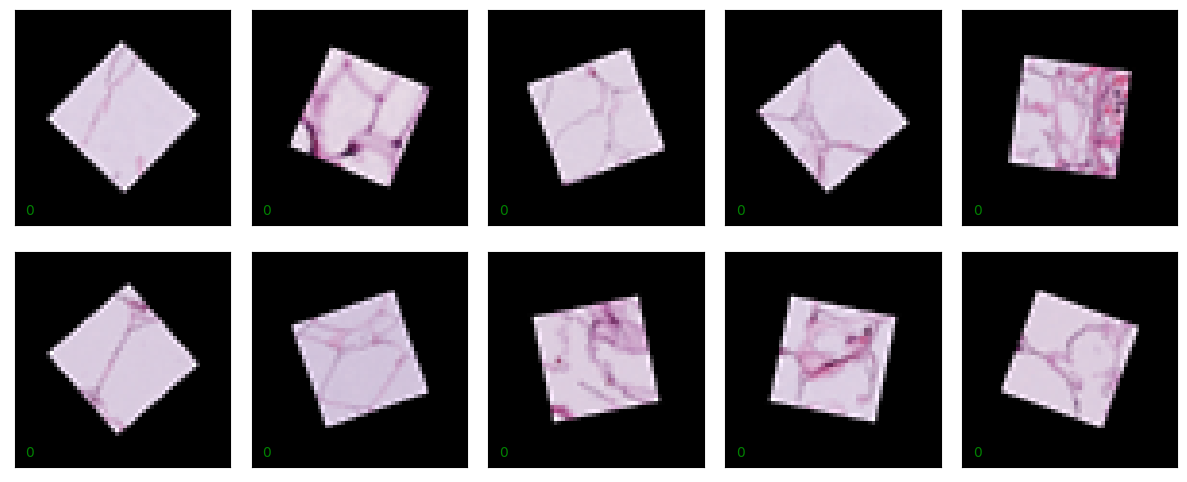

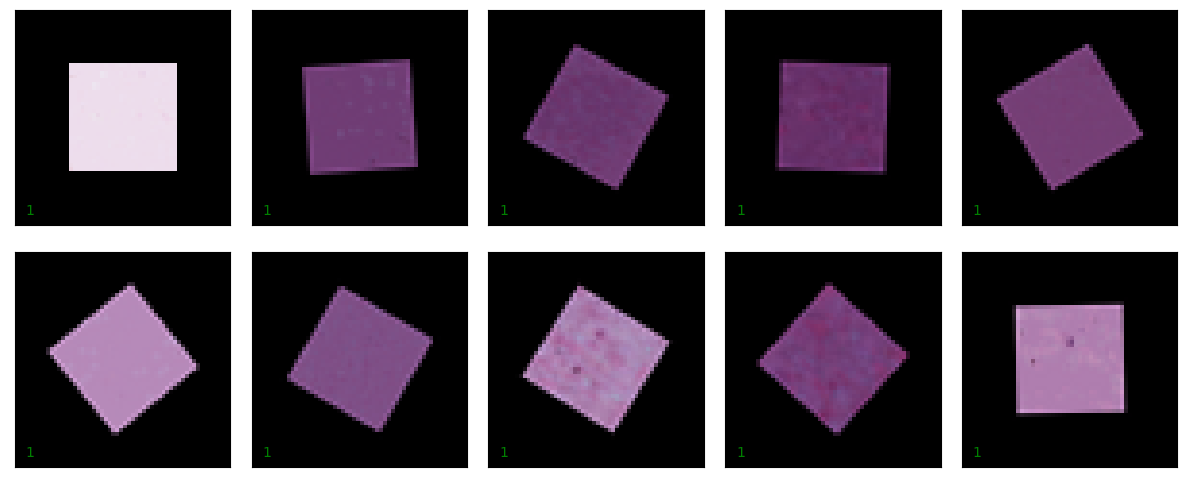

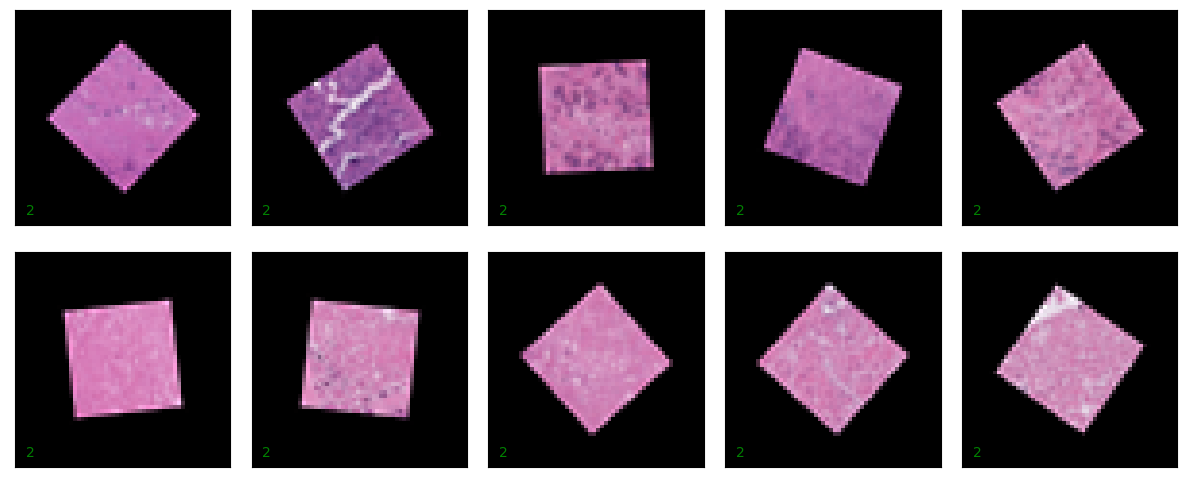

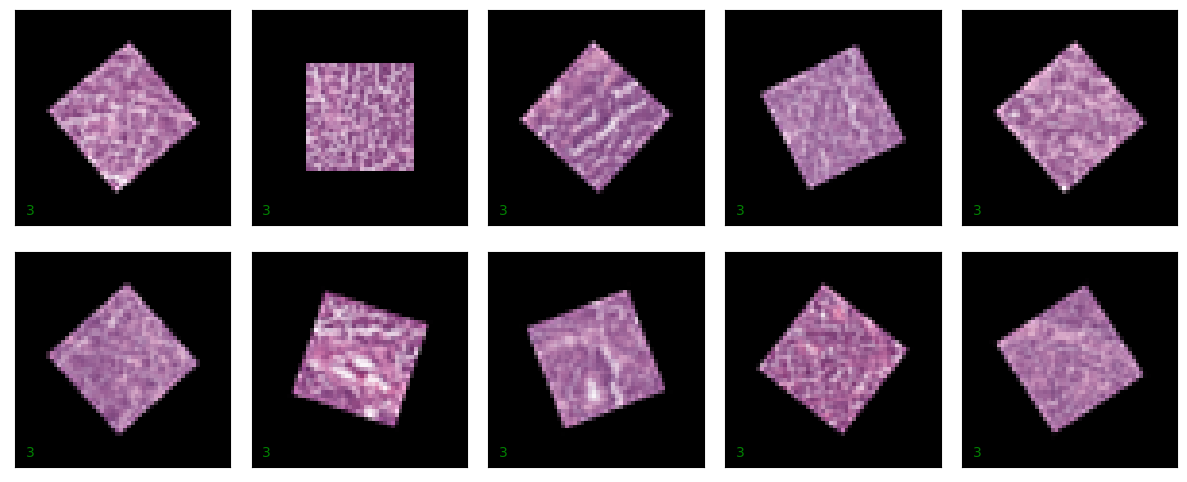

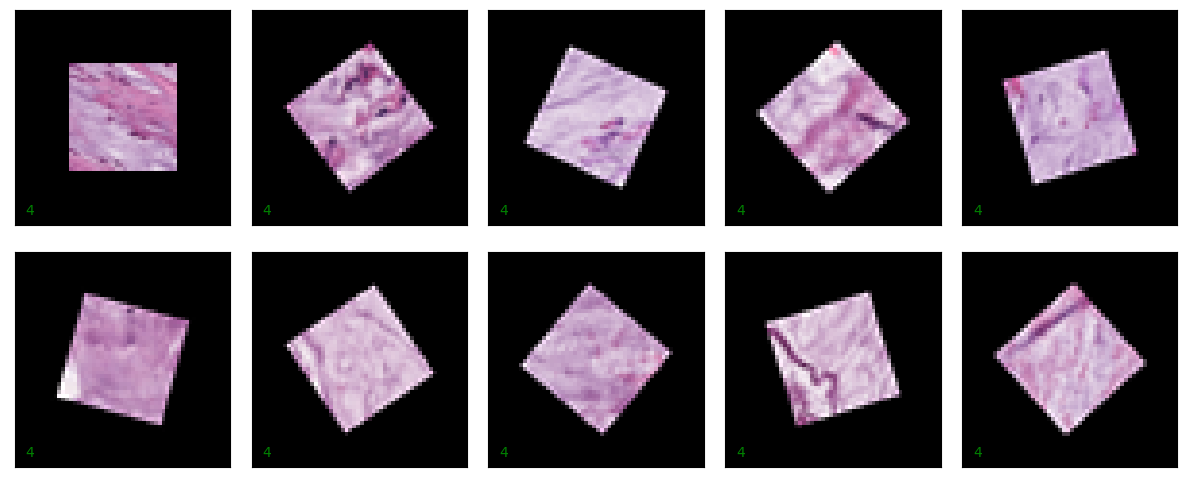

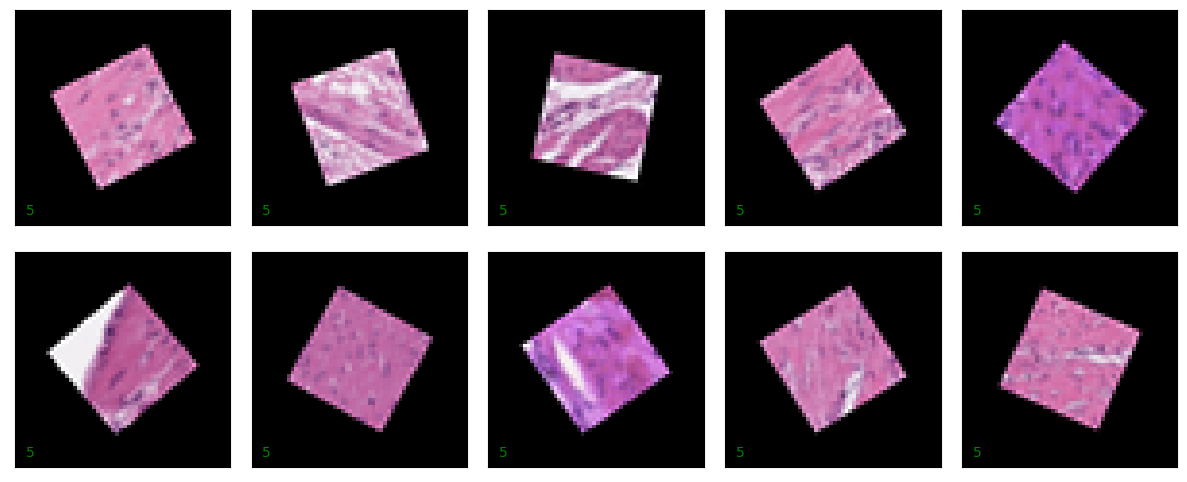

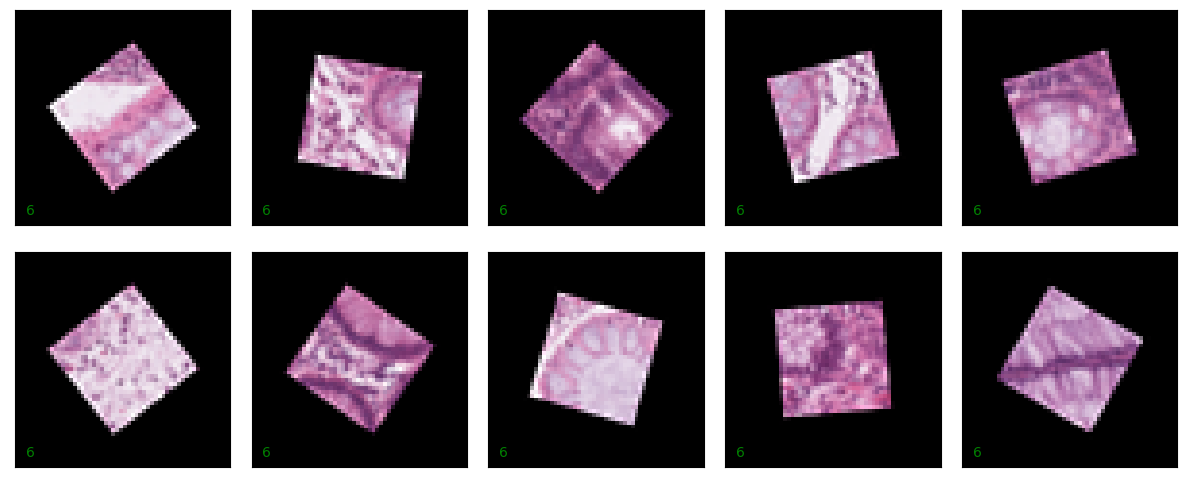

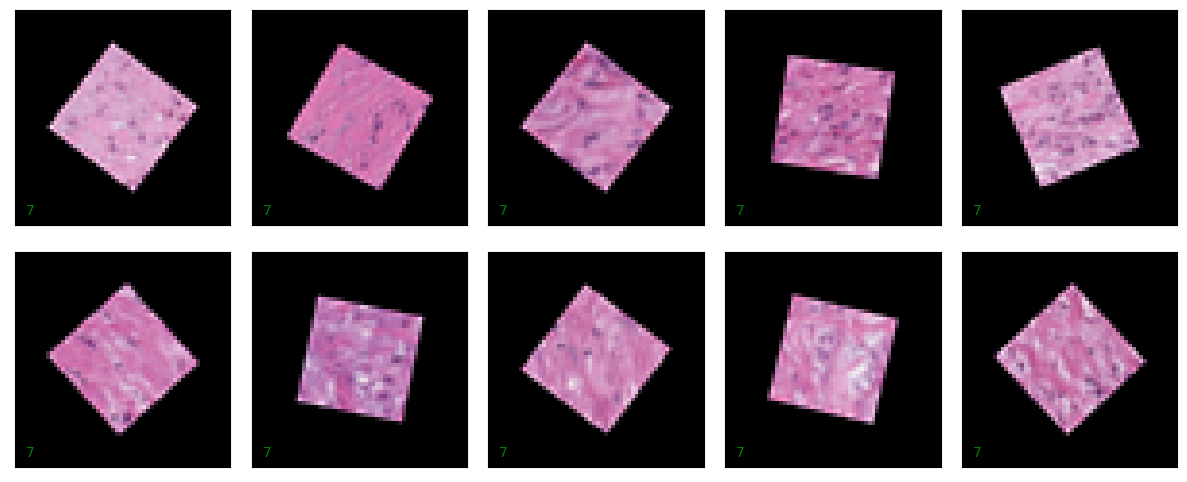

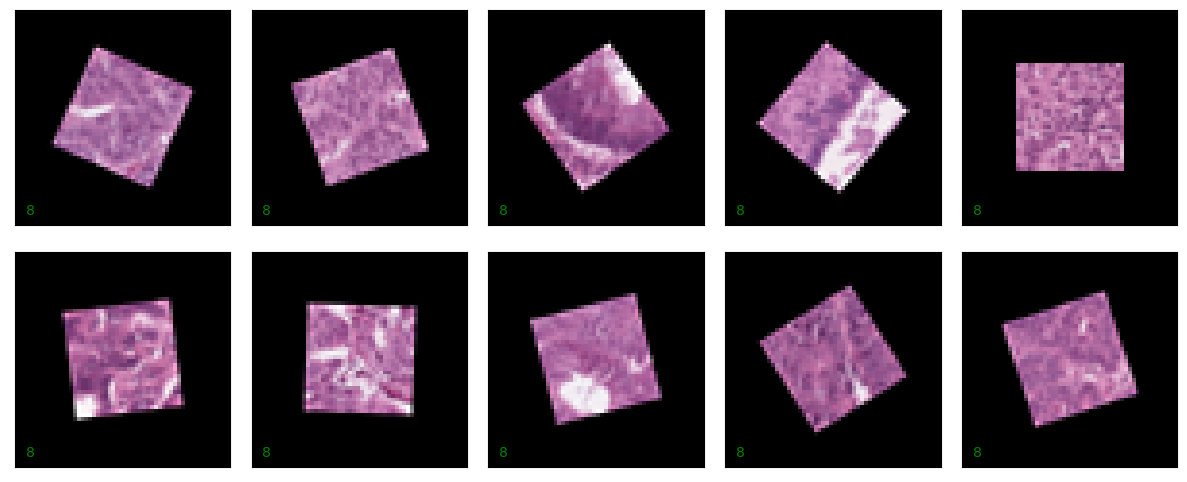

In [14]:
for i in range(9):
    train_data, train_labels, angles, translations = get_mnist_data(
        path_trainset, 
        digits = [i],
        coord = 1, 
        total_samples = 10
        )

    fig, axes = plt.subplots(2, 5, figsize=(15, 6),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for ax, im, lbl in zip(axes.flat, torch.split(train_data, 3), train_labels):
        ax.imshow(im.numpy().transpose(1, 2, 0), interpolation='nearest')
        ax.text(0.05, 0.05, str(lbl.item()),
                transform=ax.transAxes, color='green')

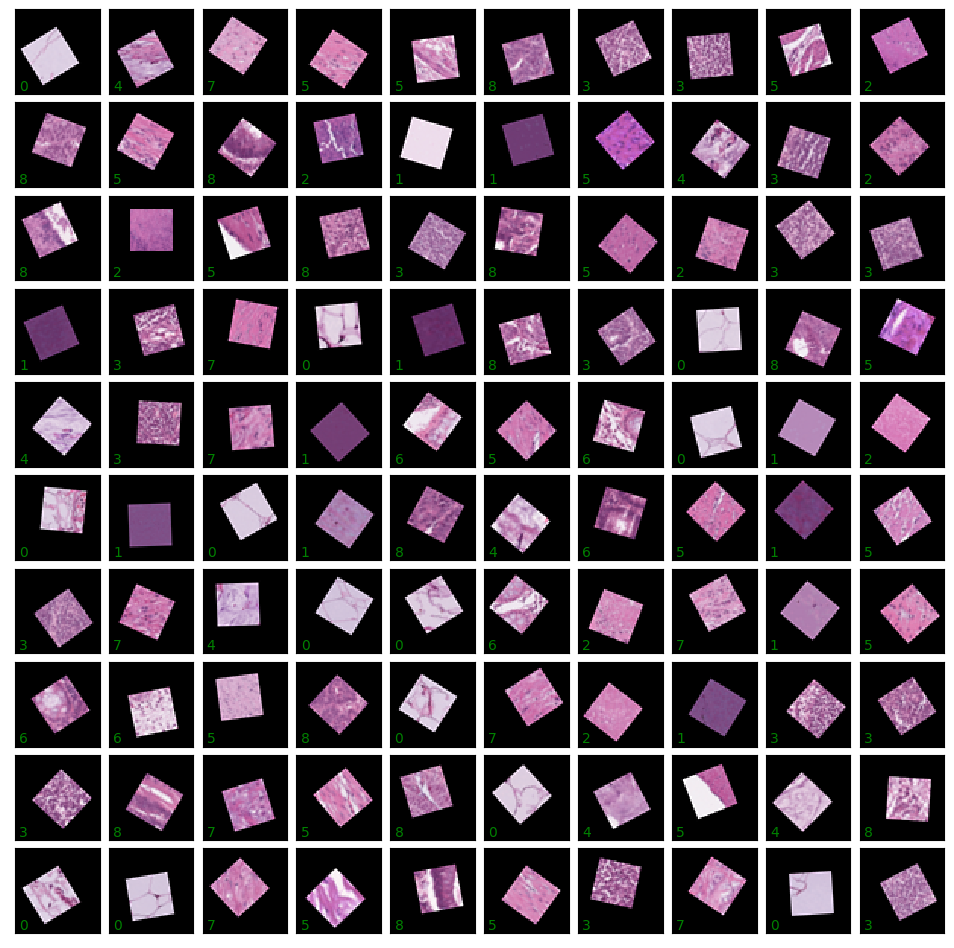

In [10]:
train_data, train_labels, angles, translations = get_mnist_data(
    path_trainset, 
    digits = [0,1,2,3,4,5,6,7,8],
    coord = 3,
    total_samples = 100
    )

fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, torch.split(train_data, 3), train_labels):
    ax.imshow(im.numpy().transpose(1, 2, 0), interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

In [9]:
train_data.shape

torch.Size([300, 56, 56])

### Trained PathMNIST Models

In [11]:
# Train on half of labels for ROC curves

# j = data_coord
# i = model_coord

# each model saved to 'saved_models/pathj_i_4.pkl'

for j in [1,2,3]:
    for i in [0,1,2,3]:
        # continue
        train_vae(path_trainset, f'path{j}_{i}_4', j, i, [0,1,2,3,4])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████████████████████████████████| 100/100 [25:51<00:00, 15.51s/it]


Epoch: 100 Training loss: 414.9535


100%|██████████████████████████████████████████████| 100/100 [39:46<00:00, 23.86s/it]


Epoch: 100 Training loss: 432.7578


100%|██████████████████████████████████████████████| 100/100 [38:18<00:00, 22.99s/it]


Epoch: 100 Training loss: 425.3333


100%|██████████████████████████████████████████████| 100/100 [40:17<00:00, 24.17s/it]


Epoch: 100 Training loss: 442.6550


100%|██████████████████████████████████████████████| 100/100 [25:48<00:00, 15.49s/it]


Epoch: 100 Training loss: 393.5983


 27%|████████████▋                                  | 27/100 [17:05<46:12, 37.97s/it]


KeyboardInterrupt: 

### Pair Matching

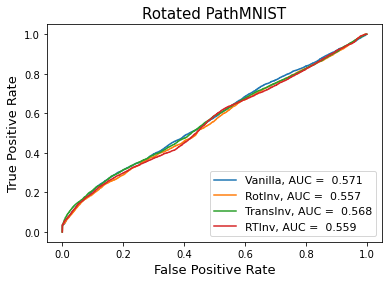

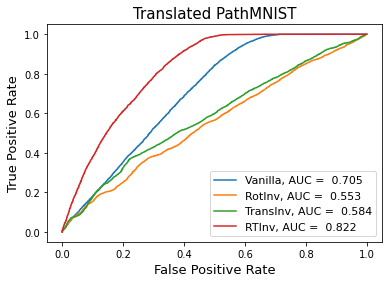

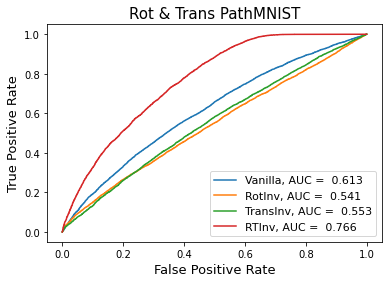

In [33]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'path{j}_{i}_4', i)
        auc, fpr, tpr, thresholds = pair_matching(path_testset, [5,6,7,8], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} PathMNIST', fontsize = 15)
    plt.show()

### Class Matching

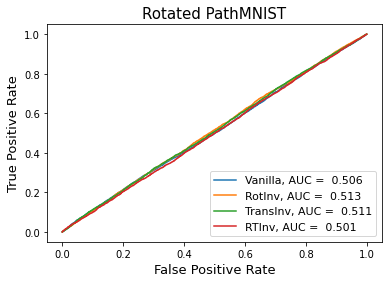

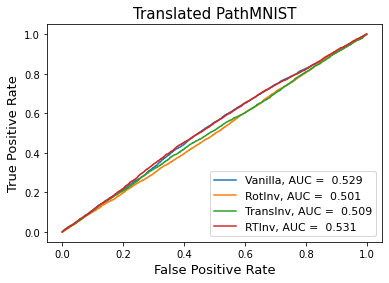

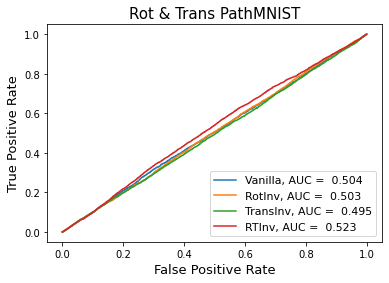

In [34]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'path{j}_{i}_4', i)
        auc, fpr, tpr, thresholds = class_matching(path_testset, [5,6,7,8], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} PathMNIST', fontsize = 15)
    plt.show()

In [8]:
print(path_trainset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: data/MedMNIST/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into traini